In [23]:
import random
import numpy as np
import torch
import torch.nn as nn #network 函式
import torch.nn.functional as F #一些方法
import torch.optim as optim #優化方法
from torchvision import datasets, transforms #提供資料集 演算法
import matplotlib.pyplot as plt #圖表
from PIL import Image, ImageFilter , ImageOps
from pathlib import Path

In [20]:
class AddGaussianNoise(object):
    """在影像中加入高斯雜訊
    
    參數:
        mean (float): 高斯雜訊的均值
        std  (float): 高斯雜訊的標準差
        p    (float): 有多大機率對影像做此增強
    """
    def __init__(self, mean=0., std=1., p=0.5):
        self.mean = mean
        self.std = std
        self.p = p

    def __call__(self, img):
        # 先以機率 p 判斷要不要施加雜訊
        if random.random() < self.p:
            # (1) 轉成 Tensor (若原本還是 PIL Image)
            if isinstance(img, Image.Image):
                img = transforms.ToTensor()(img)  # shape: [C, H, W]

            # (2) 加入高斯雜訊
            noise = torch.randn(img.size()) * self.std + self.mean
            img = img + noise

            # (3) clip 到 [0,1] 區間，確保像素值合理 (可依需求調整)
            img = torch.clamp(img, 0., 1.)

            # (4) 若需要再轉回 PIL 就執行
            img = transforms.ToPILImage()(img)

        return img

    def __repr__(self):
        return f"{self.__class__.__name__}(mean={self.mean}, std={self.std}, p={self.p})"

    
class Addblur(object):
    def __init__(self, p=0.5,blur="normal"):
        #         self.density = density
        self.p = p
        self.blur= blur

    def __call__(self, img):
        if random.uniform(0, 1) < self.p:  # 概率的判断
       		#標準模糊
            if self.blur== "normal":
                img = img.filter(ImageFilter.BLUR)
                return img
            #高斯模糊
            if self.blur== "Gaussian":
                img = img.filter(ImageFilter.GaussianBlur)
                return img
            #均值模糊
            if self.blur== "mean":
                img = img.filter(ImageFilter.BoxBlur)
                return img
        else:
            return img
        
class InvertColors(object):
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, img):
        if random.random() < self.p:# 若隨機數小於 p 則反轉顏色
            img = ImageOps.invert(img) # 若是灰階或 RGB，直接反轉
        return img

    def __repr__(self):
        return f"{self.__class__.__name__}(p={self.p})"

In [21]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64,64)), #
    transforms.ToTensor(),  # shape H，W，C —> C，H，W
    transforms.Normalize((0.1307,), (0.3081,)) # 將資料壓縮至一個範圍，例如：-1,1，這樣跑的效率會比較高
])
transformAddNoices = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64,64)), #
    AddGaussianNoise(mean=0., std=0.5, p=1),
    transforms.ToTensor(),  # shape H，W，C —> C，H，W
    transforms.Normalize((0.1307,), (0.3081,)) # 將資料壓縮至一個範圍，例如：-1,1，這樣跑的效率會比較高
])
transformAddBlur = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64,64)), #
    Addblur(p=1,blur="normal"),
    transforms.ToTensor(),  # shape H，W，C —> C，H，W
    transforms.Normalize((0.1307,), (0.3081,)) # 將資料壓縮至一個範圍，例如：-1,1，這樣跑的效率會比較高
])
transformColoeRev = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), 
    transforms.Resize((64,64)), #
    InvertColors(p=1), 
    transforms.ToTensor(),  # shape H，W，C —> C，H，W
    transforms.Normalize((0.1307,), (0.3081,)) # 將資料壓縮至一個範圍，例如：-1,1，這樣跑的效率會比較高
])
hahtransform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64,64)), #
    InvertColors(p=1), 
])

dataset = datasets.ImageFolder(root='./hiragana-dataset-master/process') #使用ImageFolder加載資料集
label_dict = dataset.class_to_idx #生出 label:index 的字典
reverse_label_dict = {v: k for k, v in label_dict.items()} #原始字典 label_dict 的key值對交換後生成一個新的字典 reverse_label_dict
print(reverse_label_dict)

{0: 'kanaA', 1: 'kanaBA', 2: 'kanaCHI', 3: 'kanaDA', 4: 'kanaE', 5: 'kanaFU', 6: 'kanaHA', 7: 'kanaHE', 8: 'kanaHI', 9: 'kanaHO', 10: 'kanaI', 11: 'kanaJI', 12: 'kanaKA', 13: 'kanaKE', 14: 'kanaKI', 15: 'kanaKO', 16: 'kanaKU', 17: 'kanaMA', 18: 'kanaME', 19: 'kanaMI', 20: 'kanaMO', 21: 'kanaMU', 22: 'kanaN', 23: 'kanaNA', 24: 'kanaNE', 25: 'kanaNI', 26: 'kanaNO', 27: 'kanaNU', 28: 'kanaO', 29: 'kanaPI', 30: 'kanaRA', 31: 'kanaRE', 32: 'kanaRI', 33: 'kanaRO', 34: 'kanaRU', 35: 'kanaSA', 36: 'kanaSE', 37: 'kanaSHI', 38: 'kanaSO', 39: 'kanaSU', 40: 'kanaTA', 41: 'kanaTE', 42: 'kanaTO', 43: 'kanaTSU', 44: 'kanaU', 45: 'kanaWA', 46: 'kanaWO', 47: 'kanaYA', 48: 'kanaYO', 49: 'kanaYU'}


kanaRO


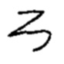

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_path = Path('./models/model_try.pt') # TODO: adjust path
assert model_path.exists() is True
image_path = Path('./hiragana-dataset-master/process/kanaRO/kanaRO19.jpg') # TODO: adjust path
assert image_path.exists() is True

model = torch.jit.load(model_path).to(device)
test_image = Image.open(image_path)
trans_image = transformColoeRev(test_image).to(device)
hahtrans_image = hahtransform(test_image)
pred = model(trans_image.unsqueeze(0))
_, pred_label = pred.max(1)
print(reverse_label_dict.get(int(pred_label)))
hahtrans_image 